In [1]:
!pip install signate

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth


auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

     |████████████████████████████████| 138 kB 4.0 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=4faf3c27aa09e881234b84da65c7ba8fa115bdd8b7620d286086236c80711b82
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.7 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Download 100%.


In [2]:
! signate list
! signate files --competition-id=492
! signate download --competition-id=492

  competitionId  title                                                                  closing     prize            submitters
---------------  ---------------------------------------------------------------------  ----------  -------------  ------------
              1  【練習問題】銀行の顧客ターゲティング                                   -                                  5140
             24  【練習問題】お弁当の需要予測                                           -                                  6328
             27  【練習問題】Jリーグの観客動員数予測                                    -                                  1432
            100  【練習問題】手書き文字認識                                             -           Knowledge               166
            102  【練習問題】タイタニックの生存予測                                     -           Knowledge              1055
            103  【練習問題】音楽ラベリング                                             -           Knowledge                60
            104  【練習問題】スパムメール分類                                     

In [3]:
# ディレクトリ内のデータの確認
%ls

adc.json                                       requirements.txt
category_names.csv                             sales_history.csv
item_categories.csv                            sample_data/
PBL01_h_exercise4_question.pdf                 sample_submission.csv
PBL01_i_exercise4_supplementary-documents.pdf  test.csv
PBL01_sample_code.ipynb


In [4]:
# Googleドライブのマウント
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#baseline

month_bining          0
id                    0
store_id              0
sales              3060
sales_before_12       0
sales_before_11       0
sales_before_10       0
sales_before_9        0
sales_before_8        0
sales_before_7        0
sales_before_6        0
sales_before_5        0
sales_before_4        0
sales_before_3        0
sales_before_2        0
category_id           0
category              0
category_detail       0
year                  0
month                 0
dtype: int64
month_bining       float64
id                 float64
store_id           float64
sales              float64
sales_before_12    float64
sales_before_11    float64
sales_before_10    float64
sales_before_9     float64
sales_before_8     float64
sales_before_7     float64
sales_before_6     float64
sales_before_5     float64
sales_before_4     float64
sales_before_3     float64
sales_before_2     float64
category_id          int64
category            object
category_detail     object
year                 

'\nスコア：\n3.7497572\n'

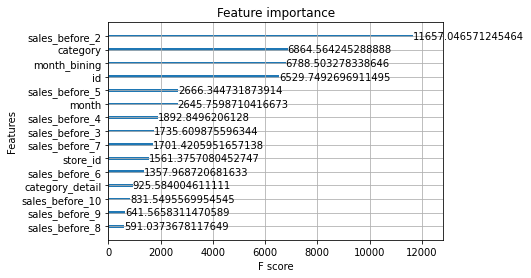

In [9]:
'''
初期設定
'''

DATA_PATH = '/content/drive/My Drive/AIQuest2021/PBL_01_需要予測/Phase2/demand/processed_data/processed_train_test_df.csv'
SAMPLESUB_PATH = 'sample_submission.csv'
SUB_PATH = '/content/drive/My Drive/AIQuest2021/PBL_01_需要予測/Phase2/demand/submit/demand_Xgboost.csv'


# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# データの読み込み
df = pd.read_csv(DATA_PATH)
print(df.isnull().sum())
print(df.dtypes)

# object型の変数の取得
categories = df.columns[df.dtypes == 'object']
print(categories)

# label Encoding
for cat in categories:
    le = LabelEncoder() 
    print(cat)
    
    df[cat].fillna('missing', inplace=True)
    le = le.fit(df[cat])
    df[cat] = le.transform(df[cat])
    # LabelEncoderは数値に変換するだけであるため、最後にastype('category')としておく
    df[cat] = df[cat].astype('int8') 

# trainとtestに分割
train = df[~df['sales'].isnull()]
test = df[df['sales'].isnull()]

# 説明変数と目的変数を指定
X_train = train.drop(['sales'], axis=1)
Y_train = train['sales']
X_test = test.drop(['sales'], axis=1)

'''
モデルの構築と評価
'''

# ライブラリのインポート
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# ハイパーパラメータの設定
params = {
    'objective':'reg:linear',
    'random_seed':1234    
}

x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train,
                                                      test_size=0.3, random_state=0,
                                                      shuffle=False)

xgb_train = xgb.DMatrix(x_train, label=y_train)
xgb_eval = xgb.DMatrix(x_valid, label=y_valid)
evals = [(xgb_train, "train"), (xgb_eval, "eval")]  
    
model = xgb.train(params, xgb_train,
                  evals=evals,
                  num_boost_round=1000,
                  early_stopping_rounds=20,
                  verbose_eval=20)   
    
y_pred = model.predict(xgb_eval)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(rmse)

# 特徴量重要度の表示
xgb.plot_importance(model, importance_type='gain',
                    max_num_features=15)

"""
予測精度：
4.650477998350093
"""

'''
テストデータの予測
'''

# テストデータにおける予測
xgb_test = xgb.DMatrix(X_test)
pred = model.predict(xgb_test)

'''
提出
'''

# 提出用サンプルの読み込み
sub = pd.read_csv(SAMPLESUB_PATH, header=None)

# カラム1の値を置き換え
sub[1] = pred

# CSVファイルの出力
sub.to_csv(SUB_PATH, header=None, index=False)

"""
スコア：
5.4010784
"""